In [2]:
from __future__ import print_function
import numpy as np
import argparse
import cv2
import imutils
from matplotlib import pyplot as plt


import sys, time, math, os

import numpy as np
from matplotlib import pylab as plt
import matplotlib.patches as mpatches
from scipy.signal import medfilt
from skimage import io
from skimage.transform import resize
from skimage.filters import sobel, threshold_yen, gaussian, median, threshold_li, threshold_isodata, threshold_otsu, \
    threshold_mean
from skimage.feature import canny
from skimage.morphology import watershed, remove_small_objects, binary_opening, remove_small_holes, dilation, disk, \
    binary_closing, erosion
from skimage.color import rgb2hsv
from skimage import exposure
from scipy import ndimage as ndi
from skimage.util import img_as_ubyte


In [119]:
def resize_image(img, max_coordinate):
    height, width, depth = img.shape
    print(width)
    print(height)
    d = max(width, height)

    if d < max_coordinate:
        if d == width:
            img = imutils.resize(img, width = max_coordinate)
        else:
            img = imutils.resize(img, height = max_coordinate)
    return img

def detect_circles(blur, d):
    circles = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT, 1.3, (int) (d / 13), param1 = 100, param2 = 75,
                               minRadius = (int) (d / 35))
    print("found " + str(circles.shape[1]) + " circle(s)")
    return circles

def draw_circles(img, circles):
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i, c in enumerate(circles[0, :]):
            cv2.circle(img, (c[0], c[1]), c[2], (255, 0, 0), 10)
    plt.imshow(img)
#     j = j + 1
#     plt.savefig("pic " + str(j) + ".png")

def avg_color(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    avg = np.mean(hsv, axis = (0,1))
    return avg

def h_to_360(h):
    return h * 360

def check_hsv_color(color):
    h = color[0]
    s = color[1]
    v = color[2]
    c = None
#     if v < .1:
#         print("error: too dark")
#         return color
    if .57 < s:
        color = 'golden'
    elif s <= .57:
        color = 'silver'
    else:
        print(f"error: h = {h_to_360(h)}, s = {s}")
    return color


def get_coin_colors(img, c):
    
    normal = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    x, y, radius = int(c[0]), int(c[1]), int(c[2])
    print(x, y, radius)

    center_delta = int(radius / 3.5)
    center = normal[y - center_delta : y + center_delta, x - center_delta : x + center_delta].copy()

    edge_delta = int(radius * .1)
    offset = int(10 / 18 * radius)

    x_from = x - offset - edge_delta
    x_to = x - offset + edge_delta
    y_from = y - offset - edge_delta
    y_to = y - offset + edge_delta

    edge = normal[y_from : y_to, x_from : x_to].copy()

    avg_center = avg_color(center)
    avg_center = [avg_center[0] / 180, avg_center[1] / 255, avg_center[2] / 255]
    avg_edge = avg_color(edge)
    avg_edge = [avg_edge[0] / 180, avg_edge[1] / 255, avg_edge[2] / 255]
    
    print(avg_center)
    print(avg_edge)

    return check_hsv_color(avg_center), check_hsv_color(avg_edge)

#     print(check_hsv_color(avg_center))
#     print(check_hsv_color(avg_edge))
    
# def count_coins(circles):
    
#     radii = []
#     detected_coins = []
    
#     circles = circles[0]
#     for circle in circles:
#         radii.append(circle[2])
#     print(circles)
        
#     min_circle = min(radii)
#     print(min_circle)
#     tolerance = 0.032258
    
#     for circle in circles:
#         current_size = circle[2] / min_circle
#         print(current_size)
#         for coin in coins:
#             potential_size = coins[coin]['size']
#             potential_value = coins[coin]['value']
#             if abs(potential_size - current_size) <= tolerance:
#                 detected_coins.append((circle[0], circle[1], potential_value))
#                 coins[coin]['count'] += 1
#                 print("found " + str(potential_value))
#     return detected_coins

480
270
found 9 circle(s)
(675, 1200, 3)
61.55555555555556
385 237 73
[0.12944097222222223, 0.526453431372549, 0.257610294117647]
[0.15603741496598642, 0.20450180072028812, 0.1954781912765106]
0
520 215 67
[0.17799707602339182, 0.09106783987833361, 0.24079083156808428]
[0.18564814814814815, 0.11397058823529412, 0.38507625272331153]
1
866 323 69
[0.14452908587257618, 0.17339362337732878, 0.17702460485579274]
[0.18472222222222223, 0.0710239651416122, 0.15841503267973858]
2
440 554 64
[0.10363082990397807, 0.29395727426773177, 0.1853879206003389]
[0.11107253086419754, 0.6303104575163399, 0.25525599128540305]
3
720 336 49
[0.18027919501133785, 0.07673069227691076, 0.14277711084433772]
[0.16440972222222222, 0.09638480392156863, 0.20606617647058822]
4
675 442 69
[0.1369998461064943, 0.5090217804573354, 0.16694639074466353]
[0.18726851851851853, 0.15479302832244007, 0.13575708061002179]
5
559 511 62
[0.14907247212610533, 0.20262229459257752, 0.15829771354908745]
[0.11624228395061728, 0.546432

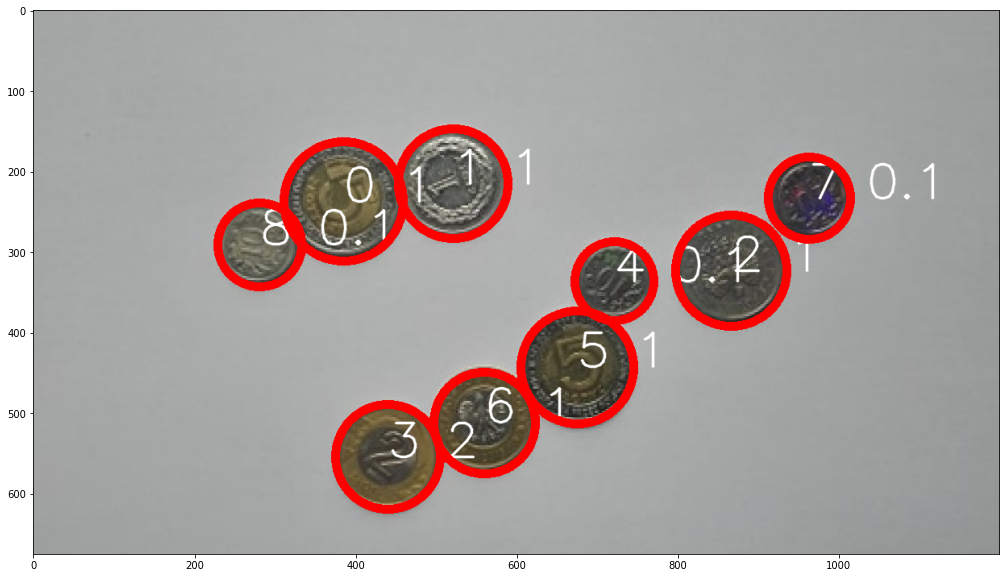

In [133]:
plt.figure(figsize=(20,10))
img = cv2.imread("jan/coins 14.jpg")
d = max(img.shape[0], img.shape[1])
# d = 10000
img = resize_image(img, 1200)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.medianBlur(gray, 9)
coin = detect_circles(gray, d)
print(img.shape)

img_gamma = adjust_gamma(img, .65)

value = 0
color = ""
radii = [int(c[2]) for c in coin[0, :]]
avg_radius = np.mean(radii)

print(avg_radius)

for i, c in enumerate(coin[0, :]):
    value = -1
    center, edge = get_coin_colors(img_gamma, c)
    if center == "golden" and edge == "golden":
        value = .01
        color = "gg"
    elif center == "silver" and edge == "golden":
        value = 2
        color = "sg"
    elif center == "golden" and edge == "silver":
        value = 5
        color = "gs"
    elif center == "silver" and edge == "silver":
        color = "ss"
        if c[2] < avg_radius:
            value = .1
        else:
            value = 1
    print(i)
    cv2.putText(img, str(i) + " " + str(value), ((int) (c[0]), (int) (c[1])), cv2.FONT_HERSHEY_SIMPLEX,
                        2, (255, 255, 255), 2, cv2.LINE_AA)

# plt.imshow(center)
# plt.imshow(edge)
draw_circles(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), coin)

139 527 61


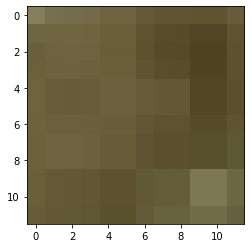

In [122]:
c = coin[0, 0]
normal = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
x, y, radius = int(c[0]), int(c[1]), int(c[2])
print(x, y, radius)
center_delta = int(radius / 3.5)
center = normal[y - center_delta : y + center_delta, x - center_delta : x + center_delta].copy()
edge_delta = int(radius * .1)
offset = int(9 / 18 * radius)
x_from = x - offset - edge_delta
x_to = x - offset + edge_delta
y_from = y - offset - edge_delta
y_to = y - offset + edge_delta

edge = normal[y_from : y_to, x_from : x_to].copy()

plt.imshow(edge)

In [74]:
plt.figure(figsize=(20,10))

img = cv2.imread("real/coins 5.jpg", cv2.IMREAD_COLOR)

d = max(img.shape[0], img.shape[1])

img = resize_image(img, 2500)

circles = detect_circles(img, d)

normal_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

cs = count_coins(circles)

draw_circles(normal_img, circles, cs)


plt.savefig("pic.jpg")

577
1280


error: OpenCV(4.4.0) /tmp/pip-req-build-zeowd5_m/opencv/modules/imgproc/src/hough.cpp:2253: error: (-215:Assertion failed) !_image.empty() && _image.type() == CV_8UC1 && (_image.isMat() || _image.isUMat()) in function 'HoughCircles'


<Figure size 1440x720 with 0 Axes>

In [4]:
coins = {
    "1gr" : {
        "value" : .01,
        "size" : 1,
        "count" : 0,
    },
    "2gr" : {
        "value" : .02,
        "size" : 1.129,
        "count" : 0,
    },
    "5gr" : {
        "value" : .05,
        "size" : 1.258,
        "count" : 0,
    },
    "10gr" : {
        "value" : .1,
        "size" : 1.0645,
        "count" : 0,
    },
    "20gr" : {
        "value" : .2,
        "size" : 1.19355,
        "count" : 0,
    },
    "50gr" : {
        "value" : .5,
        "size" : 1.3226,
        "count" : 0,
    },
    "1zl" : {
        "value" : 1,
        "size" : 1.4839,
        "count" : 0,
    },
    "2zl" : {
        "value" : 2,
        "size" : 1.3871,
        "count" : 0,
    },
    "5zl" : {
        "value" : 5,
        "size" : 1.5484,
        "count" : 0,
    },
}

In [4]:
def linear_stretching(input, lower_stretch_from, upper_stretch_from):

    lower_stretch_to = 0  # lower value of the range to stretch to - output
    upper_stretch_to = 255  # upper value of the range to stretch to - output

    output = (input - lower_stretch_from) * ((upper_stretch_to - lower_stretch_to) / (upper_stretch_from - lower_stretch_from)) + lower_stretch_to

    return output

def gamma_correction(img):
    
    max_value = np.max(img)
    min_value = np.min(img)
    
    print(min_value)
    print(max_value)

    for y in range(len(img)):
        for x in range(len(img[y])):
            img[y][x] = linear_stretching(img[y][x], min_value, max_value)

    return img

def remove_background(img, threshold):
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, threshed = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY_INV)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    morphed = cv2.morphologyEx(threshed, cv2.MORPH_CLOSE, kernel)

    cnts = cv2.findContours(morphed, 
                            cv2.RETR_EXTERNAL,
                            cv2.CHAIN_APPROX_SIMPLE)[0]

    cnt = sorted(cnts, key=cv2.contourArea)[-1]

    mask = cv2.drawContours(threshed, cnt, 0, (0, 255, 0), 0)
    masked_data = cv2.bitwise_and(img, img, mask=mask)

    x, y, w, h = cv2.boundingRect(cnt)
    dst = masked_data[y: y + h, x: x + w]

    dst_gray = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
    _, alpha = cv2.threshold(dst_gray, 0, 255, cv2.THRESH_BINARY)
    b, g, r = cv2.split(dst)

    rgba = [r, g, b, alpha]
    dst = cv2.merge(rgba, 4)

    return dst


def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)
j = 0

577
1280
7


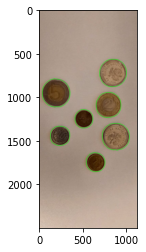

In [203]:

img = cv2.imread("real/coins 10.jpg")
d = max(img.shape[0], img.shape[1])
img = resize_image(img, 2500)
normal = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# img = adjust_gamma(img, .7)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

canny = cv2.Canny(gray, 50, 100)
kernel = np.ones((5,5),np.uint8)

blur = cv2.medianBlur(gray, 7)
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
closing = cv2.morphologyEx(th3, cv2.MORPH_CLOSE, kernel)
closing = cv2.dilate(closing, kernel)

closing = ndi.binary_fill_holes(closing)
closing = img_as_ubyte(closing)
closing = cv2.dilate(closing, kernel)
closing = cv2.dilate(closing, kernel)

contours, hierarchy = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

print(len(contours))

cv2.drawContours(normal, contours, -1, (0,255,0), 3)


plt.imshow(normal)
# plt.imshow(closing, cmap = 'gray')